In [9]:
import pandas as pd
import numpy as np
pd.options.display.max_rows = 4000
import matplotlib.pyplot as plt

In [17]:
data = pd.read_csv('QVI_data.csv')
data['DATE'] = pd.to_datetime(data['DATE'])
data['Month'] = data['DATE'].dt.to_period('M')
data.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,Month
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium,2018-10
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream,2018-09
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget,2019-03
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget,2019-03
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream,2018-11


In [18]:
#Aggregate to daily sum
Monthly_aggregate = data.groupby(['STORE_NBR', 'Month']).aggregate({'TOT_SALES' : 'sum',
                                                   'LYLTY_CARD_NBR' : 'nunique'})
Monthly_aggregate.rename(columns= {'LYLTY_CARD_NBR': '#Customers',
                                                   'TOT_SALES' : 'Sum_Sales'}, inplace= True)
Monthly_aggregate.reset_index(inplace=True)
Monthly_aggregate.head()

,STORE_NBR,Month,Sum_Sales,#Customers
0,1,2018-07,206.9,49
1,1,2018-08,176.1,42
2,1,2018-09,278.8,59
3,1,2018-10,188.1,44
4,1,2018-11,192.6,46


In [35]:
Check_missing = Monthly_aggregate.pivot(index='Month', columns=['STORE_NBR'], values='Sum_Sales')
Valid_stores_check = Check_missing.isna().sum()==0
Valid_stores = Check_missing.transpose()[Valid_stores_check].index
Valid_stores

Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
            ...
            263, 264, 265, 266, 267, 268, 269, 270, 271, 272],
           dtype='int64', name='STORE_NBR', length=260)

In [43]:
Valid_data = Monthly_aggregate[Monthly_aggregate['STORE_NBR'].isin(Valid_stores)]

In [102]:
Monthly_aggregate.head()

,STORE_NBR,Month,Sum_Sales,#Customers
0,1,2018-07,206.9,49
1,1,2018-08,176.1,42
2,1,2018-09,278.8,59
3,1,2018-10,188.1,44
4,1,2018-11,192.6,46


In [44]:
Sales_metric = Valid_data.pivot(index='STORE_NBR', columns=['Month'], values='Sum_Sales')
Sales_Euclid_eval = Sales_metric.transpose()
Sales_corr = Sales_Euclid_eval.corr()

In [45]:
Customer_metric = Valid_data.pivot(index='STORE_NBR', columns=['Month'], values='#Customers')
Customer_Euclid_eval = Customer_metric.transpose()
Customer_corr = Customer_Euclid_eval.corr()

In [46]:
def calc_euclidean(P_control, trial_store):
   return np.linalg.norm(P_control - trial_store)


In [47]:
def identify_control_stores(Sales_Euclid_eval, Sales_corr, trial_store, Customer_Euclid_eval, Customer_corr):
    Trial_store_sales_corr = Sales_corr.loc[trial_store]
    Trial_store_cust_corr = Customer_corr.loc[:][trial_store]
    Sales_distances = {}
    Cust_distances = {}
    for i in Customer_Euclid_eval.columns:
      if i!=trial_store:
        Cust_dist = calc_euclidean(Customer_Euclid_eval.loc[:][i], Customer_Euclid_eval.loc[:][trial_store])
        Cust_distances[i] = Cust_dist
    
    for i in Sales_Euclid_eval.columns:
      if i!=trial_store:
        Sales_dist = calc_euclidean(Sales_Euclid_eval.loc[:][i], Sales_Euclid_eval.loc[:][trial_store])
        Sales_distances[i] = Sales_dist
    
    Sales_Eucli_distances = pd.DataFrame.from_dict(Sales_distances, orient='index')
    Scaled_Sales_Eucli = (Sales_Eucli_distances - np.min(Sales_Eucli_distances))/(np.max(Sales_Eucli_distances) - np.min(Sales_Eucli_distances))

    Customer_Eucli_distances = pd.DataFrame.from_dict(Cust_distances, orient='index')
    Scaled_Cust_Eucli = (Customer_Eucli_distances - np.min(Customer_Eucli_distances))/(np.max(Customer_Eucli_distances) - np.min(Customer_Eucli_distances))
    
    Combined_sales = Trial_store_sales_corr.drop(index=trial_store)*(1-Scaled_Sales_Eucli[0])
    Combined_customers = Trial_store_cust_corr.drop(index=trial_store)*(1-Scaled_Cust_Eucli[0])

    Combined_metric = (0.5 * Combined_sales + 0.5 * Combined_customers)
    Final_data = pd.DataFrame(Combined_metric, index=Trial_store_sales_corr.drop(index=trial_store).index)
    return Final_data



In [48]:
control_stores_88 = identify_control_stores(Sales_Euclid_eval, Sales_corr, 88, Customer_Euclid_eval, Customer_corr)

In [51]:
control_stores_88.loc[control_stores_88[0]>0.5]

,0
STORE_NBR,
178,0.531996
201,0.580093
257,0.501005


<h2> Control Store for 88 is 201 </h2>

In [52]:
control_stores_77 = identify_control_stores(Sales_Euclid_eval, Sales_corr, 77, Customer_Euclid_eval, Customer_corr)

In [54]:
control_stores_77.loc[control_stores_77[0]>0.7]

,0
STORE_NBR,
41,0.758576
167,0.705128


<h2> Control store for 77 is 41</h2>

In [55]:
control_stores_86 = identify_control_stores(Sales_Euclid_eval, Sales_corr, 86, Customer_Euclid_eval, Customer_corr)

In [60]:
control_stores_86.loc[control_stores_86[0]>0.6]

,0
STORE_NBR,
147,0.626647
229,0.673923


<h2> Control store for 86 is 229 </h2>

<h3> Visual Inspection </h3>

In [65]:
SortedSales = Sales_metric.transpose().sort_index()

In [61]:
trial_stores = [77, 86, 88]
control_stores = [41, 229, 201]

In [62]:
SortedCustNmber = Customer_metric.transpose()

In [63]:
def compute_aggregates(store_metric, stores):  
  agg_metric = []
  for i in stores:
     agg_metric.append(store_metric[i].aggregate(np.mean))
  return agg_metric

In [66]:
SortedSales.head()

STORE_NBR,1,2,3,4,5,6,7,8,9,10,...,263,264,265,266,267,268,269,270,271,272
Month,,,,,,,,,,,,,,,,,,,,,
2018-07,206.9,150.8,1205.70,1399.9,812.0,260.0,1024.7,381.6,289.7,892.00,...,38.7,232.6,247.8,127.3,6.2,224.00,982.0,962.80,956.6,433.10
2018-08,176.1,193.8,1079.75,1259.5,745.1,203.2,1119.9,383.0,327.5,878.65,...,28.0,203.3,227.1,154.5,24.9,322.65,835.1,1003.75,683.9,372.85
2018-09,278.8,154.4,1021.50,1198.6,896.0,207.7,1147.3,293.0,369.7,945.00,...,21.8,199.5,133.5,139.0,23.3,174.40,886.0,845.40,798.4,304.70
2018-10,188.1,167.8,1037.90,1346.4,798.0,292.4,1063.9,422.8,361.0,910.80,...,36.6,170.0,162.9,170.4,14.4,237.60,1078.4,816.40,790.0,430.60
2018-11,192.6,162.9,1008.00,1212.0,771.4,255.3,1076.5,349.2,374.4,885.00,...,15.8,184.5,282.8,144.2,40.3,225.40,967.2,965.00,886.4,376.20


In [67]:
control_stores_sales = compute_aggregates(SortedSales, control_stores)
trial_stores_sales = compute_aggregates(SortedSales, trial_stores)
control_stores_customers = compute_aggregates(SortedCustNmber, control_stores)
trial_stores_customers = compute_aggregates(SortedCustNmber, trial_stores)

In [73]:
SortedSales.index.to_timestamp()

DatetimeIndex(['2018-07-01', '2018-08-01', '2018-09-01', '2018-10-01',
               '2018-11-01', '2018-12-01', '2019-01-01', '2019-02-01',
               '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01'],
              dtype='datetime64[ns]', name='Month', freq='MS')

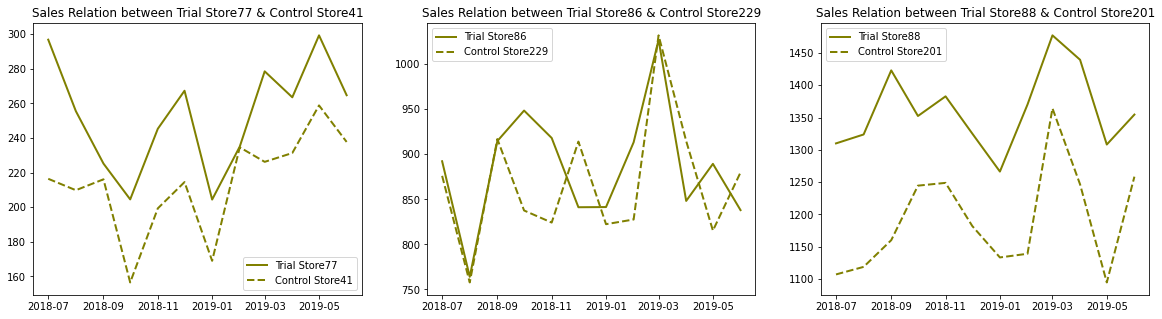

In [74]:
fig, axs = plt.subplots(1, 3, figsize=(20,5))
for i in range(len(trial_stores)):
 axs[i].plot( SortedSales.index.to_timestamp(), SortedSales[trial_stores[i]], marker='', color='olive', linewidth=2, label='Trial Store'+str(trial_stores[i]))
 axs[i].plot( SortedSales.index.to_timestamp(), SortedSales[control_stores[i]], marker='', color='olive', linewidth=2, linestyle='dashed', label="Control Store"+str(control_stores[i]))
 axs[i].set_title("Sales Relation between Trial Store"+str(trial_stores[i])+" & Control Store"+str(control_stores[i]))
 axs[i].legend()

plt.show()

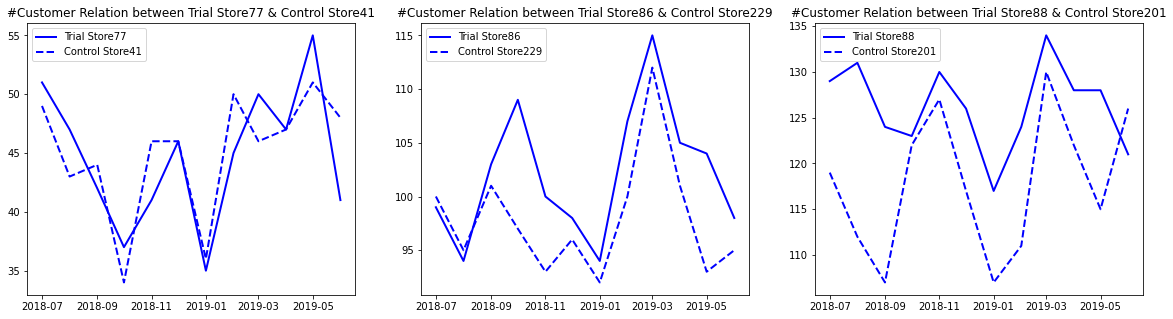

In [75]:
fig, axs = plt.subplots(1, 3, figsize=(20,5))
for i in range(len(trial_stores)):
 axs[i].plot( SortedSales.index.to_timestamp(), SortedCustNmber[trial_stores[i]], marker='', color='blue', linewidth=2, label='Trial Store'+str(trial_stores[i]))
 axs[i].plot( SortedSales.index.to_timestamp(), SortedCustNmber[control_stores[i]], marker='', color='blue', linewidth=2, linestyle='dashed', label="Control Store"+str(control_stores[i]))
 axs[i].set_title("#Customer Relation between Trial Store"+str(trial_stores[i])+" & Control Store"+str(control_stores[i]))
 axs[i].legend()

plt.show()

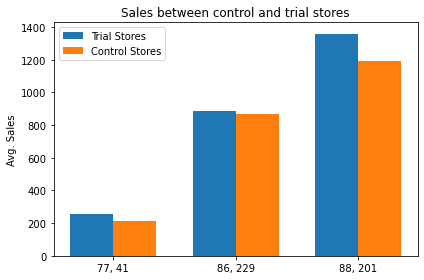

In [77]:
x = np.arange(len(trial_stores))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, trial_stores_sales, width, label='Trial Stores')
rects2 = ax.bar(x + width/2, control_stores_sales, width, label='Control Stores')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Avg. Sales')
ax.set_title('Sales between control and trial stores')
ax.set_xticks(x)
ax.set_xticklabels(['77, 41', '86, 229', '88, 201'])
ax.legend()

fig.tight_layout()


plt.show()

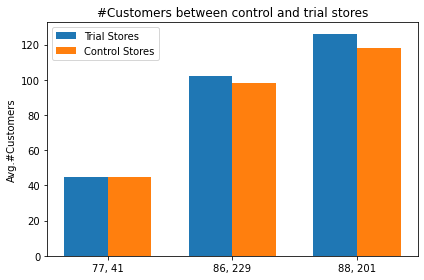

In [79]:
x = np.arange(len(trial_stores))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, trial_stores_customers, width, label='Trial Stores')
rects2 = ax.bar(x + width/2, control_stores_customers, width, label='Control Stores')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Avg.#Customers')
ax.set_title('#Customers between control and trial stores')
ax.set_xticks(x)
ax.set_xticklabels(['77, 41', '86, 229', '88, 201'])
ax.legend()

fig.tight_layout()


plt.show()

<h2> Scaling the control store's sales to a level similar to control for any differences between the two stores outside of the trial period. Scaling factor: <br>
Pretrial measure for trial store/ Pre-trial measure for control store</h2>

In [80]:
def compute_scaling_factor(trial_store_metric, control_store_metric):
    Scaling_factors = []
    for i in range(len(trial_store_metric)):
      Scaling_factors.append(trial_store_metric[i]/control_store_metric[i])
    return Scaling_factors

In [81]:
Sales_scaling_factors = compute_scaling_factor(trial_stores_sales, control_stores_sales)
Customers_scaling_factors = compute_scaling_factor(trial_stores_customers, control_stores_customers)

In [84]:
Valid_data = data[data['STORE_NBR'].isin(Valid_stores)]

,STORE_NBR,Month,Sum_Sales,#Customers
0,1,2018-07,206.9,49
1,1,2018-08,176.1,42
2,1,2018-09,278.8,59
3,1,2018-10,188.1,44
4,1,2018-11,192.6,46


In [89]:
trial_data = Valid_data[Valid_data['Month'] >= '2019-02']
trial_data.head()

,STORE_NBR,Month,Sum_Sales,#Customers
7,1,2019-02,225.4,52
8,1,2019-03,192.9,45
9,1,2019-04,192.9,42
10,1,2019-05,221.4,46
11,1,2019-06,174.1,42


In [90]:
trial_Sales_metric = trial_data.pivot(index='STORE_NBR', columns=['Month'], values='Sum_Sales').transpose()
trial_Customer_metric = trial_data.pivot(index='STORE_NBR', columns=['Month'], values='#Customers').transpose()

In [103]:
Valid_full_data = data[data['STORE_NBR'].isin(Valid_stores)]

In [106]:
trial_data = Valid_full_data[Valid_full_data['Month'] >= '2019-02']

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,Month
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget,2019-03
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget,2019-03
15,1012,2019-03-15,1,16,20,Doritos Cheese Supreme 330g,1,5.7,330,DORITOS,OLDER FAMILIES,Mainstream,2019-03
16,1012,2019-06-19,1,17,3,Kettle Sensations Camembert & Fig 150g,1,4.6,150,KETTLE,OLDER FAMILIES,Mainstream,2019-06
17,1013,2019-03-04,1,18,93,Doritos Corn Chip Southern Chicken 150g,1,3.9,150,DORITOS,RETIREES,Budget,2019-03


In [115]:
Avg_trial_data = trial_data.groupby(['STORE_NBR', 'DATE']).aggregate({'TOT_SALES': 'sum',
                                                                'LYLTY_CARD_NBR' : 'nunique'})
                                                        
Avg_trial_data.reset_index(inplace=True)
Avg_trial_data.rename(columns={'TOT_SALES' : 'Sum_Sales',
                                'LYLTY_CARD_NBR' : '#Customers'}, inplace=True)
Avg_trial_data['Month'] = Avg_trial_data['DATE'].dt.to_period('M')
Avg_trial_data.head()

,STORE_NBR,DATE,Sum_Sales,#Customers,Month
0,1,2019-02-01,4.3,1,2019-02
1,1,2019-02-02,15.1,4,2019-02
2,1,2019-02-03,2.7,1,2019-02
3,1,2019-02-04,12.1,2,2019-02
4,1,2019-02-05,7.1,2,2019-02


In [126]:
#Aggregate to monthly average metrics
Avg_month_sales = Avg_trial_data.groupby(['STORE_NBR', 'DATE']).aggregate({'Sum_Sales' : 'mean'})
Avg_customer_nmbr = Avg_trial_data.groupby(['STORE_NBR', 'DATE']).aggregate({'#Customers' : 'mean'})
Avg_month_sales.reset_index(level='STORE_NBR', inplace=True)
Avg_customer_nmbr.reset_index(level='STORE_NBR', inplace=True)

In [127]:
Control_store_data_4sales = Avg_month_sales[Avg_month_sales['STORE_NBR'].isin(control_stores)]
Control_store_data_4customers = Avg_customer_nmbr[Avg_customer_nmbr['STORE_NBR'].isin(control_stores)]

In [128]:
#Use the scaling factors to scale control stores
def scale_metric(metric_toscale, scaling_factors, key):
    Scaled_metric = pd.DataFrame()
    for i in range(len(trial_stores)):
      Scaled_metric[control_stores[i]] = metric_toscale[metric_toscale['STORE_NBR']==control_stores[i]][key] * scaling_factors[i]
    return Scaled_metric

In [129]:
Scaled_control_sales = scale_metric(Control_store_data_4sales, Sales_scaling_factors, 'Sum_Sales')
Scaled_customer_nmbr = scale_metric(Control_store_data_4customers, Customers_scaling_factors, '#Customers')

In [234]:
def compute_percent_diff(trial_metric, scaled_control_metric, key):
  Percent_diff = pd.DataFrame()
  for i in range(len(trial_stores)):
    Percent_diff[trial_stores[i]] = np.abs((trial_metric[trial_metric['STORE_NBR']==trial_stores[i]][key] - scaled_control_metric[control_stores[i]]))/scaled_control_metric[control_stores[i]]
  return Percent_diff

In [235]:
Sales_percent = compute_percent_diff(Avg_month_sales, Scaled_control_sales, 'Sum_Sales')
Customer_percent = compute_percent_diff(Avg_customer_nmbr, Scaled_customer_nmbr, '#Customers')

In [236]:
Sales_percent['Month'] = Sales_percent.index.to_period('M')
Avg_monthly_sales_percent = Sales_percent.groupby(['Month']).aggregate({77 : 'mean',
                                                                     86 : 'mean',
                                                                     88 : 'mean'})

std_monthly_sales_percent = Sales_percent.groupby(['Month']).aggregate({77 : 'std',
                                                                     86 : 'std',
                                                                     88 : 'std'})

Customer_percent['Month'] = Customer_percent.index.to_period('M')
Avg_monthly_customer_percent = Customer_percent.groupby(['Month']).aggregate({77 : 'mean',
                                                                     86 : 'mean',
                                                                     88 : 'mean'})

std_monthly_customer_percent = Customer_percent.groupby(['Month']).aggregate({77 : 'std',
                                                                     86 : 'std',
                                                                     88 : 'std'})

In [156]:
from scipy import stats

In [180]:
Trial_period = ['2019-02', '2019-03', '2019-04', '2019-05', '2019-06']

<h1> For store 77 </h1>

In [237]:
Sales_percent

,77,86,88,Month
DATE,,,,
2019-02-01,0.335710,0.596909,0.130945,2019-02
2019-02-02,3.177570,0.006269,2.216072,2019-02
2019-02-03,1.822978,0.264091,2.183400,2019-02
2019-02-04,0.799530,0.734162,0.400387,2019-02
2019-02-05,2.061938,0.159998,0.591260,2019-02
2019-02-06,0.183362,1.448885,0.272715,2019-02
2019-02-07,7.753003,0.391780,0.038763,2019-02
2019-02-08,NaN,0.550617,0.370874,2019-02
2019-02-09,NaN,NaN,NaN,2019-02


In [223]:
store77 = {}
for j in range(len(Trial_period)):
     result = stats.ttest_1samp(Sales_percent.fillna(0)[Sales_percent['Month']==Trial_period[j]][77], 0)
     store77[Trial_period[j]] = "t-stat  "+str(result.statistic) + " Pvalue: "+str(result.pvalue)

In [224]:
store77
   

{'2019-02': 't-stat  1.4356722023015696 Pvalue: 0.1625805509433203',
 '2019-03': 't-stat  0.7488836094700474 Pvalue: 0.45975918004713323',
 '2019-04': 't-stat  1.6342684592244223 Pvalue: 0.11301335364118853',
 '2019-05': 't-stat  1.8635189814163229 Pvalue: 0.07254429105761905',
 '2019-06': 't-stat  1.1323307032633063 Pvalue: 0.2667714337734813'}

<h1> For store 86</h1>

In [225]:
store86 = {}
for j in range(len(Trial_period)):
     result = stats.ttest_1samp(Sales_percent.fillna(0)[Sales_percent['Month']==Trial_period[j]][86], 0)
     store86[Trial_period[j]] = "t-stat  "+str(result.statistic) + " Pvalue: "+str(result.pvalue)

In [226]:
store86

{'2019-02': 't-stat  1.914561540654164 Pvalue: 0.0662005845529874',
 '2019-03': 't-stat  1.0096959386293916 Pvalue: 0.3207158467756178',
 '2019-04': 't-stat  1.8017958929971944 Pvalue: 0.08198294969874864',
 '2019-05': 't-stat  0.7277316847165669 Pvalue: 0.47261295866668096',
 '2019-06': 't-stat  1.2692460357584148 Pvalue: 0.2144455936476659'}

<h1>For store 88</h1>

In [227]:
store88 = {}
for j in range(len(Trial_period)):
     result = stats.ttest_1samp(Sales_percent.fillna(0)[Sales_percent['Month']==Trial_period[j]][88], 0)
     store88[Trial_period[j]] = "t-stat  "+str(result.statistic) + " Pvalue: "+str(result.pvalue)

store88

{'2019-02': 't-stat  1.629931035439523 Pvalue: 0.1147288141674219',
 '2019-03': 't-stat  1.1827638847303654 Pvalue: 0.24619193845565668',
 '2019-04': 't-stat  1.809477383916734 Pvalue: 0.08075385941102495',
 '2019-05': 't-stat  2.32901786759998 Pvalue: 0.027031447270237804',
 '2019-06': 't-stat  1.0753531933401952 Pvalue: 0.29108232064222683'}